Authors: Tim Gorman, Yu Cao, Ling Zhou

---

Data analyzed in this notebook is from [Kaggle's code competation: Foursquare - Location Matching](https://www.kaggle.com/competitions/foursquare-location-matching/data). The data comprises over one-and-a-half million place entries for hundreds of thousands of commercial Points-of-Interest (POIs) around the globe.

In [3]:
import pandas as pd
import numpy as np
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

# from googletrans import Translator, constants
import seaborn as sns
import matplotlib.pyplot as plt

from shapely.geometry import Point
from geopandas import GeoDataFrame
import geopandas as gpd

import langdetect
from langdetect import detect

# Note: To install geopandas, open a terminal in jupyter and run the following commands

# pip install pipwin 
# pipwin install gdal 
# pipwin install fiona 
# pip install geopandas

# Exploring `train.csv`

## Basic information

The official description from [Kaggle](https://www.kaggle.com/competitions/foursquare-location-matching/data):

This set comprises eleven attribute fields for over one million place entries, together with:    
 * `id` - A unique identifier for each entry.  
 * `point_of_interest` - An identifier for the POI the entry represents. There may be one or many entries describing the same POI. Two entries "match" when they describe a common POI.
 
 This data set is large (1138812 entries). Later we will decide only work with the file `pairs.csv` for our modeling.

In [ ]:
# loading data
df_train = pd.read_csv("../data_raw/train.csv")

In [ ]:
df_train.info()

In [ ]:
df_train.head()

In [ ]:
df_train.shape

## Missing values
- No missing values in the features: `id`, `latitude`, `longitude`, `point_of_interest`(POI)
- All other features have missing values
- Features with most missing values (top 3): `url`, `phone`, `zip`.
- only one missing value in `name`

In [ ]:
df = df_train.copy()
# Count the missing values in each feature
missing = df.isna().sum()/df.shape[0]*100
print(missing.sort_values())

# Plot the percentages of missing values for each feature
import matplotlib.ticker as mtick
tmp = df.isna().sum().sort_values()
fig, ax = plt.subplots(figsize=(8,6))

y = tmp/len(df)*100
ax.barh(tmp.index, y)
ax.set_title("Missing values", fontsize=18)
# ax.axvline(x=60,color='r',linestyle='--')
# ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.tick_params(axis='both', labelsize=15 )
ax.set_ylabel('features', fontsize=18)
ax.set_xlabel('percentages (%)', fontsize=18)
ax.set_xlim(0,100)

for index, value in enumerate(y):
    if value < 1:
        ax.text(value, index, '{:.6f}'.format(value), color = 'red', fontweight = 'bold')
    else:
        ax.text(value, index, '{:.1f}'.format(value), color = 'red', fontweight = 'bold')
plt.show()

## Features in `train.csv`

- We verify that the `id` feature is indeed a unique identifier for each entry.

- We explore in this section the features that have fewer missing values:
    - latitude and longitude
    - name
    - country
    - point_of_interest

- We explore entries that have the same POI.

In [ ]:
print(df.columns.values)

### `id` (no missing values)

In [ ]:
# each value in `id` is indeed unique.
print("Each value in `id` is unique:", len(df.id.unique()) == df.shape[0])

### `latitude` and `longitude` (no missing values)
This (combination of) feature(s) shows that the places are all over the world, mostly in the US and the European regions.


In [ ]:
# # fancy plot
# geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
# gdf = GeoDataFrame(df_train.copy(), geometry=geometry)   

# #this is a simple map that goes with geopandas
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# fig, ax = plt.subplots(figsize=(20, 12))
# world.plot(figsize=(20, 12), ax=ax)
# gdf.plot(ax=ax, marker='o', color='red', markersize=10)

# fig.savefig("./train_coords.png")
# plt.show()

### `name`

This column has different languages. 

#### How many languages are present in `name`?

We sample 10K names and find that roughly 20% of the sampled data is in English. The second most frequent language is about less than 8%.

In [ ]:
def lang_detect(x):
    ''' language detect with exception handling '''
    
    try:
        return detect(x)
    except:
        # print names that cause exception.
        print(x,end=' ')
        return np.nan

df = df_train.copy()
tmp = df['name'].sample(10000).fillna('').str.replace('[{}]'.format(string.punctuation),'',regex=True).str.lower()
lang_sample = tmp.apply(lang_detect)

In [ ]:
lang_stats = lang_sample.value_counts()*100/lang_sample.value_counts().sum()
lang_stats = lang_stats.head(10).sort_values()

fig, ax = plt.subplots(figsize=(8,6))
color = ["gray"]*len(lang_stats.index)
color[-1] = '#1f77b4'
lang_stats.plot(kind = 'barh', ax = ax, color = color)

ax.set_title("languages appearing in the name (top 10)", fontsize = 18)
ax.set_ylabel('language', fontsize = 18)
ax.set_xlabel('Percentages (%)', fontsize = 18)
for index, value in enumerate(lang_stats.values):
    if value < 1:
        ax.text(value, index, '{:.6f}'.format(value), color = 'red', fontweight = 'bold')
    else:
        ax.text(value, index, '{:5.1f}'.format(value), color = 'red', fontweight = 'bold')
ax.set_xlim(0,25)
plt.show()

### `country` 

Data availability in the `country` feature.


In [ ]:
df = df_train.copy()
country_stats = df['country'].value_counts()*100/df['country'].value_counts().sum()
country_stats = country_stats.head(10).sort_values()
print(country_stats.shape)

fig, ax = plt.subplots(figsize=(8,6))
color = ["gray"]*len(country_stats.index)
color[-1] = '#1f77b4'
country_stats.plot(kind = 'barh', ax = ax, color = color)

ax.set_title("Available Data by Countries (top 10)", fontsize = 18)
ax.set_ylabel('country', fontsize = 18)
ax.set_xlabel('Percentages (%)', fontsize = 18)
for index, value in enumerate(country_stats.values):
    if value < 1:
        ax.text(value, index, '{:.6f}'.format(value), color = 'red', fontweight = 'bold')
    else:
        ax.text(value, index, '{:5.1f}'.format(value), color = 'red', fontweight = 'bold')
ax.set_xlim(0,25)
plt.show()

### `point_of_interest`

Notes on the `point_of_interest` feature:
https://www.kaggle.com/competitions/foursquare-location-matching/discussion/318967#1783581

In [ ]:
print('There are {} distinct POIs.'.format(df.point_of_interest.nunique()))
print('Abount {:.2f} %POIs are uniue'.format(df.point_of_interest.nunique()*100/df.point_of_interest.shape[0]))

In [ ]:
most_freq_POI = df['point_of_interest'].value_counts().head(10)
most_freq_POI

In [ ]:
tmp = df[df['point_of_interest']==most_freq_POI.keys().values[0]].sort_values(by='name')
tmp.head()

In [ ]:
tmp = df[df['point_of_interest']==most_freq_POI.keys().values[4]].sort_values(by='name')
tmp.head()

In [ ]:
tmp = df[df['point_of_interest']==most_freq_POI.keys().values[3]].sort_values(by='name')
tmp.head()

# Exploring the US data in `train.csv`

In [ ]:
df_us = df[df['country']=='US'].copy()

In [ ]:
df_us.info()

## Missing values
- No missing values in the features: `id`, `latitude`, `longitude`, `point_of_interest`(POI)
- All other features have missing values
- Features with most missing values (top 3): `url`, `phone`, `address`.
- only one missing value in `name`

In [ ]:
df = df_us.copy()
# Count the missing values in each feature
missing = df.isna().sum()/df.shape[0]*100
print(missing.sort_values())

# Plot the percentages of missing values for each feature
import matplotlib.ticker as mtick
tmp = df.isna().sum().sort_values()
fig, ax = plt.subplots(figsize=(8,6))

y = tmp/len(df)*100
ax.barh(tmp.index, y)
ax.set_title("Missing values", fontsize=18)
# ax.axvline(x=60,color='r',linestyle='--')
# ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.tick_params(axis='both', labelsize=15 )
ax.set_ylabel('features', fontsize=18)
ax.set_xlabel('percentages (%)', fontsize=18)
ax.set_xlim(0,100)

for index, value in enumerate(y):
    if value < 1:
        ax.text(value, index, '{:.6f}'.format(value), color = 'red', fontweight = 'bold')
    else:
        ax.text(value, index, '{:5.1f}'.format(value), color = 'red', fontweight = 'bold')
plt.show()

## Features

### `latitude` and `longitude`

In [ ]:
# fancy plot
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df.copy(), geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(20, 12))
world.plot(figsize=(20, 12), ax=ax)
gdf.plot(ax=ax, marker='o', color='red', markersize=10)

fig.savefig("./train_coords_us.png")
plt.show()

# fig, ax = plt.subplots(figsize=(40,10))
# ax.scatter(df_us['longitude'],df_us['latitude'])
# ax.set_xlabel('longitude',fontsize=40)
# ax.set_ylabel('latitude',fontsize=40)
# ax.tick_params(axis='both', labelsize=40)
# ax.set_title('US data',fontsize=40)
# ax.grid()
# plt.show()

### `name`

In [ ]:
tmp = df_us['name'].sort_values()
tmp

In [ ]:
def lang_detect(x):
    ''' language detect with exception handling '''
    
    try:
        return detect(x)
    except:
        # print names that cause exception.
        print(x,end=' ')
        return np.nan

tmp = df['name'].sample(10000).fillna('').str.replace('[{}]'.format(string.punctuation),'',regex=True).str.lower()
lang_sample = tmp.apply(lang_detect)

In [ ]:
lang_stats = lang_sample.value_counts()*100/lang_sample.value_counts().sum()
lang_stats = lang_stats.head(10).sort_values()

fig, ax = plt.subplots(figsize=(8,6))
color = ["gray"]*len(lang_stats.index)
color[-1] = '#1f77b4'
lang_stats.plot(kind = 'barh', ax = ax, color = color)

ax.set_title("languages appearing in the name (top 10)", fontsize = 18)
ax.set_ylabel('language', fontsize = 18)
ax.set_xlabel('Percentages (%)', fontsize = 18)
for index, value in enumerate(lang_stats.values):
    if value < 1:
        ax.text(value, index, '{:.6f}'.format(value), color = 'red', fontweight = 'bold')
    else:
        ax.text(value, index, '{:5.1f}'.format(value), color = 'red', fontweight = 'bold')
ax.set_xlim(0,50)
plt.show()

### `state`

- We can filter non US data by looking at the `state` feature. 
- It turns out that the state codes are not in the same format. 

In [ ]:
df_us['state'].unique()

In [ ]:
# # Drop these.
# filter_set = ['国外','UK','CE','ON/NY','Capital Region of Denmark','BCN','Tamaulipas','NU']
# df_us[df_us['state'].isin(filter_set)]

### `categories`

In [ ]:
df_us.loc[df_us['categories'].notna(),'categories'].sort_values()

### `point_of_interest`

In [ ]:
df = df_us.copy()
print('There are {} distinct POIs.'.format(df.point_of_interest.nunique()))
print('Abount {:.2f} %POIs are uniue'.format(df.point_of_interest.nunique()*100/df.point_of_interest.shape[0]))

In [ ]:
most_freq_POI = df['point_of_interest'].value_counts().head(10)
most_freq_POI

In [ ]:
tmp = df[df['point_of_interest']==most_freq_POI.keys().values[0]].sort_values(by='name')
tmp.head()

In [ ]:
tmp = df[df['point_of_interest']==most_freq_POI.keys().values[1]].sort_values(by='name')
tmp.head()

In [ ]:
tmp = df[df['point_of_interest']==most_freq_POI.keys().values[2]].sort_values(by='name')
tmp.head()

# Exploring and Manipulating `pairs.csv`

Official description of the data:

`pairs.csv` - A pregenerated set of pairs of place entries from train.csv designed to improve detection of matches. You may wish to generate additional pairs to improve your model's ability to discriminate POIs.
        
`match` - Whether (True or False) the pair of entries describes a common POI (in `train.csv`).

The file `pairs.csv` is a subset of pairs from `train.csv`. The value of `match` is "True" if an only if the pair has the same `point_of_interest` (POI) value in `train.csv`. We will focus on the US pairs. 
print('There are {} unique id_1s'.format(df_pairs.id_1.nunique()])

## Basic information

In [4]:
# # Tim loading
# df_pairs = pd.read_csv(r'C:\Users\gorma\OneDrive\Documents\Erdos\foursquare-location-matching\data_raw\pairs.csv')
# Yu loading
df_pairs = pd.read_csv('../data_raw/pairs.csv')

In [5]:
print(df_pairs.shape)
df_pairs.head()

(578907, 25)


,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,...,longitude_2,address_2,city_2,state_2,zip_2,country_2,url_2,phone_2,categories_2,match
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,...,3.635206,NaN,NaN,NaN,NaN,BE,NaN,NaN,Bars,True
1,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,...,27.845560,batı aydın,aydın,NaN,67500,TR,NaN,NaN,Electronics Stores,False
2,E_000023d8f4be44,Island Spa,14.518970,121.018702,"5th Flr, Newport Mall, Resorts World Manila",Pasay City,Metro Manila,NaN,PH,NaN,...,121.019827,NaN,NaN,NaN,NaN,PH,NaN,NaN,Spas,True
3,E_00007dcd2bb53f,TOGO'S Sandwiches,38.257797,-122.064599,"1380 Holiday Ln., Ste. B",Fairfield,CA,94534,US,https://locations.togos.com/ll/US/CA/Fairfield...,...,-122.064606,NaN,Fairfield,CA,NaN,US,NaN,NaN,Sandwich Places,True
4,E_0000c362229d93,Coffee Cat,7.082218,125.610244,F. Torres St.,Davao City,Davao Region,8000,PH,NaN,...,125.611457,E. Jacinto Extension,Davao City,Davao Region,8000,PH,NaN,NaN,"Coffee Shops, Cafés, Dessert Shops",False


In [6]:
print('There are {} pairs'.format(df_pairs.shape[0]))
print('There are {} unique id_1s'.format(df_pairs.id_1.nunique()))
print('There are {} unique id_2s'.format(df_pairs.id_2.nunique()))


There are 578907 pairs
There are 464765 unique id_1s
There are 565512 unique id_2s


In [7]:
df_pairs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578907 entries, 0 to 578906
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id_1          578907 non-null  object 
 1   name_1        578907 non-null  object 
 2   latitude_1    578907 non-null  float64
 3   longitude_1   578907 non-null  float64
 4   address_1     475383 non-null  object 
 5   city_1        512928 non-null  object 
 6   state_1       452316 non-null  object 
 7   zip_1         359509 non-null  object 
 8   country_1     578899 non-null  object 
 9   url_1         231806 non-null  object 
 10  phone_1       270022 non-null  object 
 11  categories_1  562613 non-null  object 
 12  id_2          578907 non-null  object 
 13  name_2        578907 non-null  object 
 14  latitude_2    578907 non-null  float64
 15  longitude_2   578907 non-null  float64
 16  address_2     312497 non-null  object 
 17  city_2        367490 non-null  object 
 18  stat

In [8]:
df_pairs_us = df_pairs[(df_pairs.country_1=='US') & (df_pairs.country_2=='US')].copy()
df_pairs_us.shape

(117708, 25)

Henceforth, we will focus on the pairs data with country_1 and country_2 both being `US`.

id_1             0.000000
country_2        0.000000
longitude_2      0.000000
latitude_2       0.000000
name_2           0.000000
country_1        0.000000
id_2             0.000000
latitude_1       0.000000
name_1           0.000000
longitude_1      0.000000
match            0.000000
state_1          1.144357
city_1           1.979475
categories_1     2.031298
state_2          3.189248
city_2           5.092262
zip_1            5.754069
categories_2     8.227138
address_1       12.632956
zip_2           19.490604
address_2       30.754069
phone_1         32.663880
url_1           43.553539
phone_2         55.640228
url_2           70.559350
dtype: float64


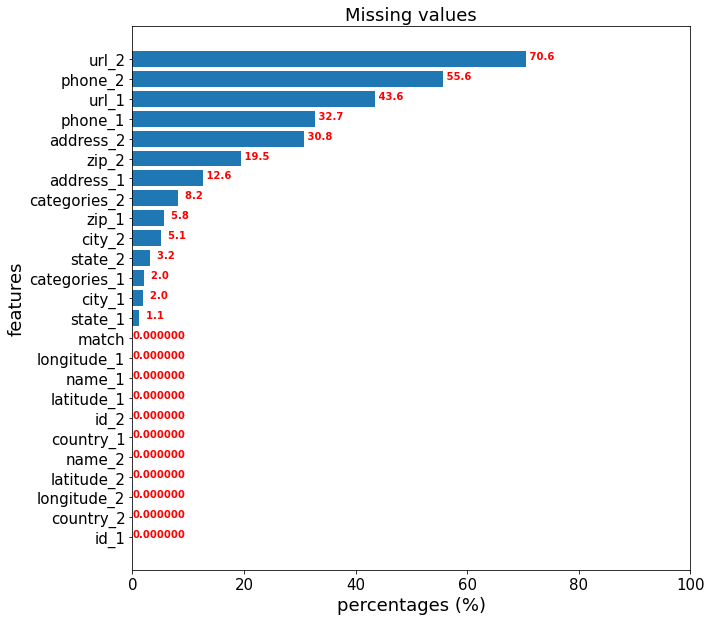

In [9]:
df = df_pairs_us.copy()
# Count the missing values in each feature
missing = df.isna().sum()/df.shape[0]*100
print(missing.sort_values())

# Plot the percentages of missing values for each feature
import matplotlib.ticker as mtick
tmp = df.isna().sum().sort_values()
fig, ax = plt.subplots(figsize=(10,10))

y = tmp/len(df)*100
ax.barh(tmp.index, y)
ax.set_title("Missing values", fontsize=18)
# ax.axvline(x=60,color='r',linestyle='--')
# ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.tick_params(axis='both', labelsize=15 )
ax.set_ylabel('features', fontsize=18)
ax.set_xlabel('percentages (%)', fontsize=18)
ax.set_xlim(0,100)

for index, value in enumerate(y):
    if value < 1:
        ax.text(value, index, '{:.6f}'.format(value), color = 'red', fontweight = 'bold')
    else:
        ax.text(value, index, '{:5.1f}'.format(value), color = 'red', fontweight = 'bold')
plt.show()

## Data cleaning

In [10]:
df = df_pairs_us.copy()
# reindexing the subset.
df.reset_index(drop=True, inplace=True)

In [11]:
# fill missing value with empty string.
df.fillna('', inplace=True)
# df.isna().sum()


In [12]:
import string
string_features = ['name_1', 'name_2',
                   'address_1', 'address_2', 
                   'city_1', 'city_2',
                   'state_1', 'state_2', 
                   'zip_1', 'zip_2',
                   'country_1', 'country_2', 
                   'url_1', 'url_2',
                   'phone_1', 'phone_2', 
                   'categories_1', 'categories_2']

df[string_features] = df[string_features].fillna('').astype(str).apply(
    lambda x: x.str.lower().str.replace('[{}]'.format(string.punctuation),'',regex=True))

# The original data type of the position_features is already float64
# position_features = ['latitude_1', 'latitude_2', 'longitude_1', 'longitude_2']
# df[position_features] = df[position_features].astype('float64')
# df.head()

In [13]:
# two letter US state code from 
# https://www.bls.gov/respondents/mwr/electronic-data-interchange/appendix-d-usps-state-abbreviations-and-fips-codes.htm
# saved in state-code.csv
# Notes: Don't be confused with FIPS Code: 56 is not the total; some numbers are missing.

state = pd.read_csv('../data_raw/state-code.csv', header=None)
state.columns=['state','code']
state['state'] = state['state'].str.upper()
state.head()

,state,code
0,ALABAMA,AL
1,ALASKA,AK
2,ARIZONA,AZ
3,ARKANSAS,AR
4,CALIFORNIA,CA


In [14]:
# Unify the format of the state code
print('before unified:')
print(df['state_1'].unique())
print(df['state_2'].unique())
dict_lookup = dict(zip(state['state'],state['code']))
dict_lookup['CALIF']  = 'CA'
# dict_lookup['D.C.']   = 'DC'
dict_lookup['ONNY']  = 'NY'

df['state_1'] = df['state_1'].str.upper()
df['state_2'] = df['state_2'].str.upper()

for x in dict_lookup.keys():
    
    df.loc[df["state_1"] == x, "state_1"] = dict_lookup[x]
    df.loc[df["state_2"] == x, "state_2"] = dict_lookup[x]

print(78*'*-')
print('after unified:')
print(df['state_1'].unique())
print(df['state_2'].unique())

before unified:
['ca' 'ga' 'nm' 'fl' 'va' 'tn' 'nj' 'ut' 'in' 'nc' 'wi' '' 'nv' 'ks' 'ma'
 'ms' 'az' 'mi' 'ny' 'tx' 'il' 'al' 'pa' 'ok' 'ar' 'ky' 'mo' 'wv' 'co'
 'ne' 'oh' 'or' 'mt' 'ct' 'nh' 'calif' 'md' 'hi' 'wa' 'wy' 'ri' 'vt' 'ia'
 'mn' 'la' 'sc' 'nd' 'de' 'dc' 'sd' 'ak' 'id' 'me' 'new york'
 'north carolina' 'virginia' 'district of columbia' 'ohio' 'texas'
 'california' 'kentucky' 'ce' 'kansas' 'arizona' 'illinois' 'missouri'
 'onny' 'wisconsin' 'iowa' 'south carolina' 'georgia' 'tennessee'
 'maryland']
['ca' 'ga' 'nm' 'fl' 'va' 'tn' '' 'nj' 'calif' 'ut' 'in' 'nc' 'wi' 'nv'
 'ks' 'ma' 'ms' 'az' 'mi' 'ny' 'tx' 'il' 'al' 'pa' 'ok' 'ar' 'ky' 'wv'
 'co' 'ne' 'oh' 'or' 'mt' 'sc' 'ct' 'nh' 'mo' 'md' 'hi' 'wa' 'wy' 'vt'
 'ia' 'mn' 'la' 'nd' 'de' 'pennsylvania' 'illinois' 'dc' 'sd' 'nevada'
 'ak' 'id' 'me' 'texas' 'arkansas' 'ri' 'new york' 'florida' 'michigan'
 'ohio' 'new jersey' 'connecticut' 'north carolina' 'georgia' 'virginia'
 'colorado' 'california' 'missouri' 'uk' 'louisiana' 'te

Throw away rows with the `state` codes that are not in `state-code.csv`.

In [15]:
print(set(df['state_1'].unique()).difference(set(state['code'])))
print(set(df['state_2'].unique()).difference(set(state['code'])))
S1 = set(df['state_1'].unique())
S2 = set(df['state_2'].unique())
S  = set(state['code'])
drop_list = S1.union(S2).difference(S)
print(drop_list)
drop_list.remove('')
print(drop_list) # drop_list = ['UK', 'CE', 'NU', '国外']

{'', 'CE'}
{'', 'CE', '国外', 'NU', 'UK'}
{'', 'CE', '国外', 'NU', 'UK'}
{'CE', '国外', 'NU', 'UK'}


In [16]:
df = df[df['state_1'].isin(drop_list)==False] 
df = df[df['state_2'].isin(drop_list)==False] 
print(df['state_1'].unique())
print(df['state_2'].unique())
tmp1 = df['state_1'].unique()
tmp2 = df['state_2'].unique()
print('state code  missed in state_1:')
print(set(state['code']).difference(set(tmp1)))
print('state code  missed in state_2:')
print(set(state['code']).difference(set(tmp2)))
print(df.shape)

['CA' 'GA' 'NM' 'FL' 'VA' 'TN' 'NJ' 'UT' 'IN' 'NC' 'WI' '' 'NV' 'KS' 'MA'
 'MS' 'AZ' 'MI' 'NY' 'TX' 'IL' 'AL' 'PA' 'OK' 'AR' 'KY' 'MO' 'WV' 'CO'
 'NE' 'OH' 'OR' 'MT' 'CT' 'NH' 'MD' 'HI' 'WA' 'WY' 'RI' 'VT' 'IA' 'MN'
 'LA' 'SC' 'ND' 'DE' 'DC' 'SD' 'AK' 'ID' 'ME']
['CA' 'GA' 'NM' 'FL' 'VA' 'TN' '' 'NJ' 'UT' 'IN' 'NC' 'WI' 'NV' 'KS' 'MA'
 'MS' 'AZ' 'MI' 'NY' 'TX' 'IL' 'AL' 'PA' 'OK' 'AR' 'KY' 'WV' 'CO' 'NE'
 'OH' 'OR' 'MT' 'SC' 'CT' 'NH' 'MO' 'MD' 'HI' 'WA' 'WY' 'VT' 'IA' 'MN'
 'LA' 'ND' 'DE' 'DC' 'SD' 'AK' 'ID' 'ME' 'RI']
state code  missed in state_1:
{'VI', 'PR'}
state code  missed in state_2:
{'VI', 'PR'}
(117703, 25)


No data pairs in Puerto Rico (PR) or Virgin Islands (VI).

## Feature analysis

---
The available pairs of features include:

```
'name', 'latitude', 'longitude', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories'
```

In [17]:
print(df.columns.values)

['id_1' 'name_1' 'latitude_1' 'longitude_1' 'address_1' 'city_1' 'state_1'
 'zip_1' 'country_1' 'url_1' 'phone_1' 'categories_1' 'id_2' 'name_2'
 'latitude_2' 'longitude_2' 'address_2' 'city_2' 'state_2' 'zip_2'
 'country_2' 'url_2' 'phone_2' 'categories_2' 'match']


### True vs False in the `match` feature

In [18]:
tmp = df.groupby('match')['match'].count()
tmp

match
False    33096
True     84607
Name: match, dtype: int64

In [19]:
print('False/True: {}'.format(tmp.loc[0]/tmp.loc[1]))

False/True: 0.39117330717316534


We can subset the data (randomly) further to make it 50/50. 

### Comparing the numeric feature (latitude, longitude)


---
We compute the L^\infty distance for (latitude, longitude) of each US pair. 

[The following needs supported examples.]
  * Locations with small distance (less than 0.001) may have different POIs: stores are next to each other in a shopping center. In some extreme cases, places with identical coordinates can have different POI. For example, one classroom can be located vertically on top of another.  
  * Conversely, locations physically far can represent the same POI, such as mountains.

In [20]:
# Compute the L^\infty difference of (latitude, longitude) of each pair in df_pairs.csv
df['location_diff'] = pd.concat([(df['latitude_1']-df['latitude_2']).abs(), 
                                 (df['longitude_1']-df['longitude_2']).abs()], axis=1).max(axis=1)

df.location_diff.describe()

count    117703.000000
mean          0.087312
std           1.425253
min           0.000000
25%           0.000293
50%           0.001116
75%           0.005862
max         222.460965
Name: location_diff, dtype: float64

The following strip plots show that location difference alone is not useful for determining the POI.

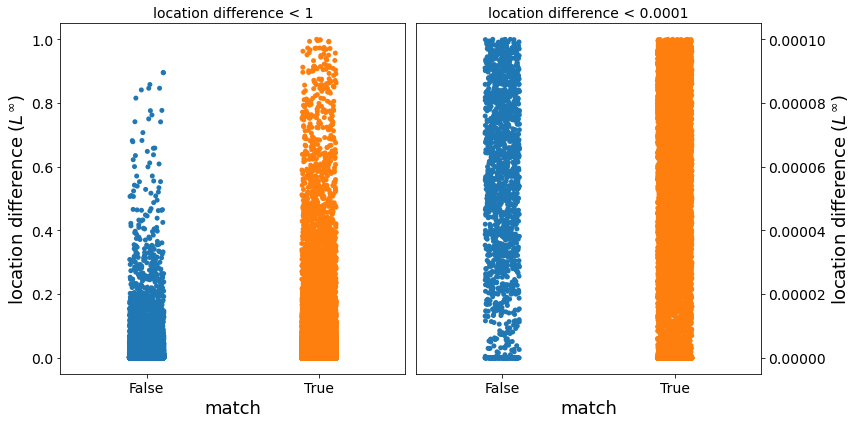

In [21]:
fig, axs = plt.subplots(1,2,figsize = (12,6))
sns.stripplot(x="match", y="location_diff", data=df.loc[df.location_diff<1], ax=axs[0])
axs[0].set_ylabel(r"location difference ($L^\infty$)", fontsize=18)
axs[0].set_xlabel("match", fontsize=18)
axs[0].set_title('location difference < 1',fontsize=14)
axs[0].tick_params(labelsize=14)

sns.stripplot(x="match", y="location_diff", data=df.loc[df.location_diff<0.0001], ax=axs[1])
axs[1].set_ylabel(r"location difference ($L^\infty$)", fontsize=18)
axs[1].set_xlabel("match", fontsize=18)
axs[1].set_title('location difference < 0.0001',fontsize=14)
axs[1].tick_params(labelsize=14)
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")
plt.tight_layout()
plt.show()

In [22]:
# fig, ax = plt.subplots(figsize = (8,6))
# sns.stripplot(x="match", y="location_diff", data=df.loc[df.location_diff==0],ax=ax)
# ax.set_ylabel(r"location difference", fontsize=18)
# ax.set_xlabel("match", fontsize=18)
# ax.tick_params(labelsize=14)
# plt.show()

In [23]:
def myprint(eps):
    tmp = len(df.loc[(df.location_diff<=eps) & (df.match==False)])
    total = len(df)
    if eps == 0:
        print('There are {:5d} (US) pairs with location difference ={:.5f} but different POIs, out of all {:2.2f}% (US) pairs.'.format(
          tmp, eps, tmp*100/total))
    else:
        print('There are {:5d} (US) pairs with location difference<={:.5f} but different POIs, out of all {:2.2f}% (US) pairs.'.format(
          tmp, eps, tmp*100/total))

myprint(1)
myprint(0.0001)
myprint(0)

There are 33005 (US) pairs with location difference<=1.00000 but different POIs, out of all 28.04% (US) pairs.
There are  1639 (US) pairs with location difference<=0.00010 but different POIs, out of all 1.39% (US) pairs.
There are   146 (US) pairs with location difference =0.00000 but different POIs, out of all 0.12% (US) pairs.


In [24]:
# print('There are',len(df.loc[(df.location_diff==0) & (df.match==False)]),
#       'df_pairs with location_diff=0 but different POIs, out of all',len(df_pairs),'df_pairs.')

### straight line distance and angular (great circle) distance

In [25]:
def get_diff(df,func,*feature,name=None,sim=None):
    '''Get difference of given feature using input metric
    
    df:      data frame of pairs
    func:    metric to apply
    feature: features to compare with the metric
    name:    new feature name
    
    '''
    if name is None:
        name = feature[0]+'_diff'
    if sim is None:
        sim = 'difference'
    else:
        sim = 'similarity'
    
    print('Getting {} in {} with the "{}" metric.'.format(sim,feature,func.__name__))
    
    print('Making new column "{}"'.format(name))
    print()
    cols = [str(x)+'_1' for x in feature]+[str(x)+'_2' for x in feature]   
    df[name] = df[cols].apply(func, axis=1)


In [26]:
def l2_metric(pair):
    ''' Euclidean distance (l2) for comparing geographic coordinates
    
    '''
    a = np.asarray(pair[0],pair[1])
    b = np.asarray(pair[2],pair[3])
    return np.linalg.norm(a-b)

In [27]:
def theta_diff(pair):
    ''' Great circle distance for geographic coordinates
    
    https://en.wikipedia.org/wiki/Great-circle_distance#Computational_formulas
    
    '''
    PI = np.pi
    
    phi_1, phi_2 = pair[0], pair[1] #latitudes
    lam_1, lam_2 = pair[2], pair[3] #longitudes
    
    # convert to radians for calculation:
    for x in [phi_1,phi_2,lam_1,lam_2]:
        x = np.deg2rad(x)
    
    del_lam = lam_1 - lam_2
    
    p = np.cos(phi_2)*np.sin(del_lam)
    q = np.cos(phi_1)*np.sin(phi_2) - np.sin(phi_1)*np.cos(phi_2)*np.cos(del_lam)
    r = np.sin(phi_1)*np.sin(phi_2) + np.cos(phi_1)*np.cos(phi_2)*np.cos(del_lam)
    
    diff = np.arctan(np.sqrt(p**2+q**2)/r)
    
    return np.abs(diff)

In [28]:
feature = ('latitude','longitude')
get_diff(df,l2_metric,*feature,name='geo_diff')
get_diff(df,theta_diff,*feature,name='geo_theta_diff')

Getting difference in ('latitude', 'longitude') with the "l2_metric" metric.
Making new column "geo_diff"

Getting difference in ('latitude', 'longitude') with the "theta_diff" metric.
Making new column "geo_theta_diff"



In [29]:
print(df.columns.values)

['id_1' 'name_1' 'latitude_1' 'longitude_1' 'address_1' 'city_1' 'state_1'
 'zip_1' 'country_1' 'url_1' 'phone_1' 'categories_1' 'id_2' 'name_2'
 'latitude_2' 'longitude_2' 'address_2' 'city_2' 'state_2' 'zip_2'
 'country_2' 'url_2' 'phone_2' 'categories_2' 'match' 'location_diff'
 'geo_diff' 'geo_theta_diff']


In [ ]:
# ### name

#   * There are some true pairs with slightly different names, e.g. short name v.s. full name.
#   * Conversely, there are false pairs with the same name, e.g. chain stores in different cities.

In [ ]:
# df.loc[df.match==True,['name_1','name_2','match']].sample(20)

### Comparing string features using different metrics
Most columns in this data are strings. We consider different metrics for string comparison letter by letter, including:
*   `SequenceMatcher`
*   `Levenshtein distance`

or word by word using

*  `CountVectorizer` and `cosine_similarity`

If one value of a pair of features is missing, we set the distance to be -1.

In [30]:
def l2_metric(pair):
    ''' Euclidean distance (l2) for comparing geographic coordinates
    
    '''
    a = np.asarray(pair[0],pair[1])
    b = np.asarray(pair[2],pair[3])
    return np.linalg.norm(a-b)

In [31]:
from difflib import SequenceMatcher
def seq_metric(pair):
    ''' metric for comparing strings
    
    '''
    a,b = tuple(pair)
    if type(a)!=str or type(b)!=str:
        return -1
    else:
        # from Ling.
        a = a.lower().replace(" ", "").replace("'", "")
        b = b.lower().replace(" ", "").replace("'", "")
        # b = b.lower().replace('[{}]'.format(string.punctuation),'').replace(" ", "")
    return 1-SequenceMatcher(None, a, b).ratio()


In [32]:
from Levenshtein import distance as lev
def lev_metric(pair):
    ''' Levenshtein metric for comparing strings
    
    '''
    a,b = tuple(pair)
    if type(a)!=str or type(b)!=str:
        return -1
    elif len(a)==0 or len(b)==0:
        return -1
    else:
        a = a.lower().replace(" ", "").replace("'", "")
        b = b.lower().replace(" ", "").replace("'", "")
    return lev(a,b)/max(len(a),len(b))

In [33]:
print(df.columns.values)
print()

feature = ('latitude','longitude')
get_diff(df,l2_metric,*feature,name='geo_diff')

features = ['name','address','city','state','zip','url','phone','categories']
features = [[x] for x in features]
for feature in features:
    get_diff(df,seq_metric,*feature,name=feature[0]+'_diff_seq')
    get_diff(df,lev_metric,*feature,name=feature[0]+'_diff_lev')
print(df.columns.values)

['id_1' 'name_1' 'latitude_1' 'longitude_1' 'address_1' 'city_1' 'state_1'
 'zip_1' 'country_1' 'url_1' 'phone_1' 'categories_1' 'id_2' 'name_2'
 'latitude_2' 'longitude_2' 'address_2' 'city_2' 'state_2' 'zip_2'
 'country_2' 'url_2' 'phone_2' 'categories_2' 'match' 'location_diff'
 'geo_diff' 'geo_theta_diff']

Getting difference in ('latitude', 'longitude') with the "l2_metric" metric.
Making new column "geo_diff"

Getting difference in ('name',) with the "seq_metric" metric.
Making new column "name_diff_seq"

Getting difference in ('name',) with the "lev_metric" metric.
Making new column "name_diff_lev"

Getting difference in ('address',) with the "seq_metric" metric.
Making new column "address_diff_seq"

Getting difference in ('address',) with the "lev_metric" metric.
Making new column "address_diff_lev"

Getting difference in ('city',) with the "seq_metric" metric.
Making new column "city_diff_seq"

Getting difference in ('city',) with the "lev_metric" metric.
Making new column "ci

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import string

def cos_sim(pair):
    ''' cosine_sim metric for comparing strings
    
    '''
    a,b = tuple(pair)

    try:
        if (a == '') | (b == ''):
            csim = -1
        elif (a == ' ') | (b == ' '):
            csim = -1
        else:
            csim = cosine_similarity(CountVectorizer().fit_transform([a,b]).toarray())[0][1]
        return csim
    except ValueError:
        print(a,b)
        csim = -1
        return csim
    
features = ['name','address','city','state','zip','url','phone','categories']
features = [[x] for x in features]
for feature in features:
    get_diff(df,cos_sim,*feature,name=feature[0]+'_csim')
print(df.columns.values)

Getting difference in ('name',) with the "cos_sim" metric.
Making new column "name_csim"

Getting difference in ('address',) with the "cos_sim" metric.
Making new column "address_csim"

1 1
n 
Getting difference in ('city',) with the "cos_sim" metric.
Making new column "city_csim"

1 1
Getting difference in ('state',) with the "cos_sim" metric.
Making new column "state_csim"

Getting difference in ('zip',) with the "cos_sim" metric.
Making new column "zip_csim"

Getting difference in ('url',) with the "cos_sim" metric.
Making new column "url_csim"

Getting difference in ('phone',) with the "cos_sim" metric.
Making new column "phone_csim"

0 0
Getting difference in ('categories',) with the "cos_sim" metric.
Making new column "categories_csim"

['id_1' 'name_1' 'latitude_1' 'longitude_1' 'address_1' 'city_1' 'state_1'
 'zip_1' 'country_1' 'url_1' 'phone_1' 'categories_1' 'id_2' 'name_2'
 'latitude_2' 'longitude_2' 'address_2' 'city_2' 'state_2' 'zip_2'
 'country_2' 'url_2' 'phone_2' 'ca

In [35]:
df.columns

Index(['id_1', 'name_1', 'latitude_1', 'longitude_1', 'address_1', 'city_1',
       'state_1', 'zip_1', 'country_1', 'url_1', 'phone_1', 'categories_1',
       'id_2', 'name_2', 'latitude_2', 'longitude_2', 'address_2', 'city_2',
       'state_2', 'zip_2', 'country_2', 'url_2', 'phone_2', 'categories_2',
       'match', 'location_diff', 'geo_diff', 'geo_theta_diff', 'name_diff_seq',
       'name_diff_lev', 'address_diff_seq', 'address_diff_lev',
       'city_diff_seq', 'city_diff_lev', 'state_diff_seq', 'state_diff_lev',
       'zip_diff_seq', 'zip_diff_lev', 'url_diff_seq', 'url_diff_lev',
       'phone_diff_seq', 'phone_diff_lev', 'categories_diff_seq',
       'categories_diff_lev', 'name_csim', 'address_csim', 'city_csim',
       'state_csim', 'zip_csim', 'url_csim', 'phone_csim', 'categories_csim'],
      dtype='object')

---


## Histogram

What do we conclude from the histograms?

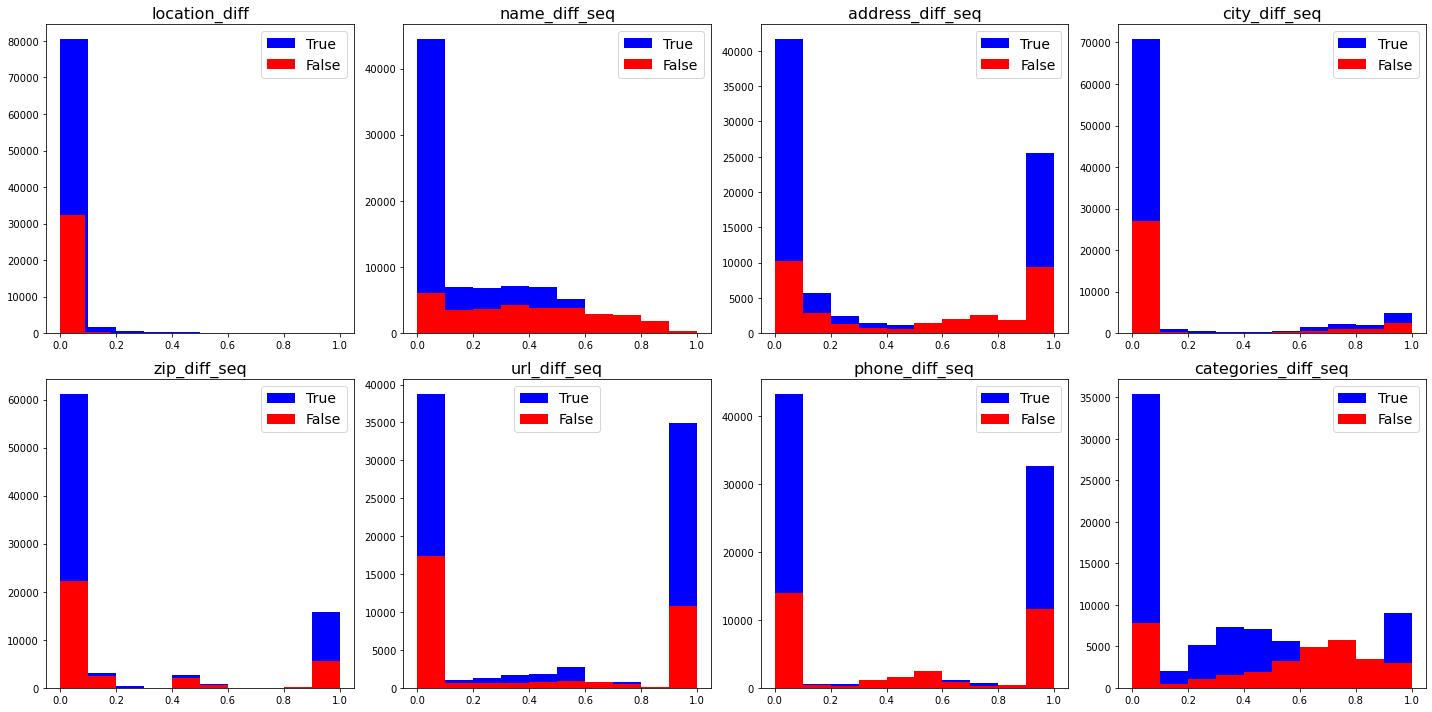

In [65]:
## histograms for SequenceMatcher

columns = ['location_diff','name_diff_seq','address_diff_seq','city_diff_seq',
           'zip_diff_seq','url_diff_seq', 'phone_diff_seq', 'categories_diff_seq','match']
df_pairs_seq = df[columns].copy()

fig, axs = plt.subplots(2,4,figsize=(20,10))
columns = np.array(columns[:-1]).reshape(2,-1)
for i in range(2):
    for j in range(4):
        column=columns[i,j]
        axs[i,j].hist(df_pairs_seq.loc[(df_pairs_seq.match==True)&(df_pairs_seq.location_diff<1), column], color='b', label="True")
        axs[i,j].hist(df_pairs_seq.loc[(df_pairs_seq.match==False)&(df_pairs_seq.location_diff<1), column], color='r', label="False")
        axs[i,j].legend(fontsize=14)
        axs[i,j].set_title(column,fontsize=16)
        # print(np.array2string(column))

plt.tight_layout()
plt.show()

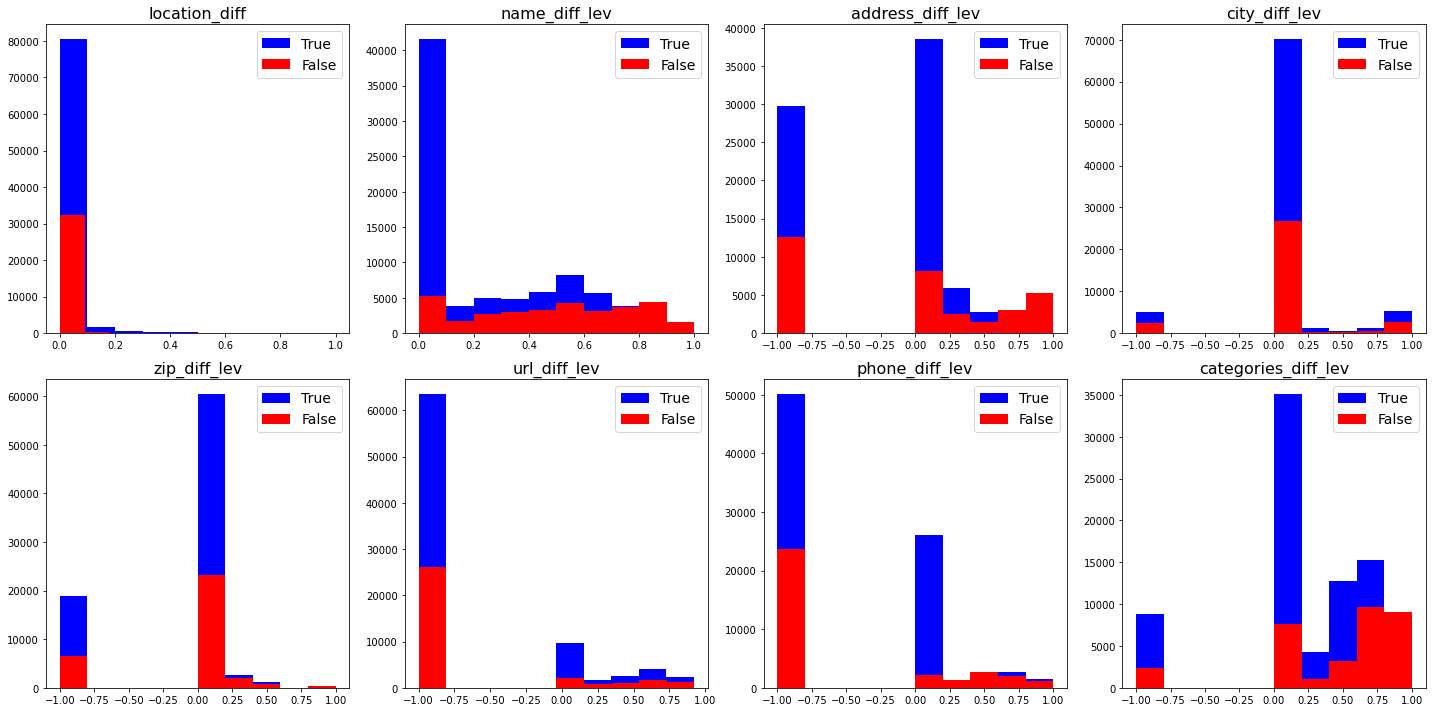

In [67]:
# Histogram for Levenshtein distance

# columns = ['location_diff','name_diff','address_diff','city_diff','zip_diff','url_diff', 'phone_diff', 'categories_diff']

# for i in range(len(columns)):
#     column=columns[i]
#     plt.hist(df_pairs_lev.loc[(df_pairs_lev.match==True)&(df_pairs_lev.location_diff<1), column], color='b', label="True")
#     plt.hist(df_pairs_lev.loc[(df_pairs_lev.match==False)&(df_pairs_lev.location_diff<1), column], color='r', label="False")
#     plt.legend(fontsize=14)
#     plt.title(column,fontsize=16)
#     plt.show()

## histograms for SequenceMatcher

columns = ['location_diff','name_diff_lev','address_diff_lev','city_diff_lev',
           'zip_diff_lev','url_diff_lev', 'phone_diff_lev', 'categories_diff_lev','match']
df_pairs_seq = df[columns].copy()

fig, axs = plt.subplots(2,4,figsize=(20,10))
columns = np.array(columns[:-1]).reshape(2,-1)
for i in range(2):
    for j in range(4):
        column=columns[i,j]
        axs[i,j].hist(df_pairs_seq.loc[(df_pairs_seq.match==True)&(df_pairs_seq.location_diff<1), column], color='b', label="True")
        axs[i,j].hist(df_pairs_seq.loc[(df_pairs_seq.match==False)&(df_pairs_seq.location_diff<1), column], color='r', label="False")
        axs[i,j].legend(fontsize=14)
        axs[i,j].set_title(column,fontsize=16)
        # print(np.array2string(column))

plt.tight_layout()
plt.show()

## Tim Prep for Cosine Similarities: Filling NAs and  Making Combined Full Addresses

In [ ]:
df_pairs['categories_1']   = df_pairs['categories_1'].fillna('')
df_pairs['categories_2']   = df_pairs['categories_2'].fillna('')
df_pairs['full_address_1'] = df_pairs['address_1'].fillna('') + ' ' + df_pairs['city_1'].fillna('') + ' ' + df_pairs['state_1'].fillna('') + ' ' + df_pairs['zip_1'].fillna('')  + ' ' + df_pairs['country_1'].fillna('')

In [ ]:
df_pairs['full_address_1'] = df_pairs['address_1'].fillna('') + ' ' + df_pairs['city_1'].fillna('') + ' ' + df_pairs['state_1'].fillna('') + ' ' + df_pairs['zip_1'].fillna('')  + ' ' + df_pairs['country_1'].fillna('')
df_pairs['full_address_2'] = df_pairs['address_2'].fillna('') + ' ' + df_pairs['city_2'].fillna('') + ' ' + df_pairs['state_2'].fillna('') + ' ' + df_pairs['zip_2'].fillna('')  + ' ' + df_pairs['country_2'].fillna('')

---



# Reducing `pairs.csv` to only US data (ALREADY MOVED TO THE PREVIOUS SECTION. WILL BE DELETED.)

Now following the article "Calculating STring Similarity in Python"

In [ ]:
pairs_red_us['name_1']

In [ ]:
pairs_red_us['name_1'] = pairs_red_us['name_1'].str.replace('[{}]'.format(string.punctuation),'')
pairs_red_us['name_2'] = pairs_red_us['name_2'].str.replace('[{}]'.format(string.punctuation),'')
pairs_red_us['full_address_1'] = pairs_red_us['full_address_1'].str.replace('[{}]'.format(string.punctuation),'')
pairs_red_us['full_address_2'] = pairs_red_us['full_address_2'].str.replace('[{}]'.format(string.punctuation),'')
pairs_red_us['categories_1'] = pairs_red_us['categories_1'].str.replace('[{}]'.format(string.punctuation),'')
pairs_red_us['categories_2'] = pairs_red_us['categories_2'].str.replace('[{}]'.format(string.punctuation),'')

In [ ]:
pairs_red_us['name_1'].iloc[0]

In [ ]:
pairs_red_us.head()

In [ ]:
pairs_red_us = pairs_red_us.reset_index().drop('index', axis = 1)

In [ ]:
pairs_red_us.head()

In [ ]:
pairs_red_us.to_csv(r'C:\Users\gorma\OneDrive\Documents\Erdos\foursquare-location-matching\tim_code\working_data\pairs_reduced_us.csv')

In [ ]:
vectors = CountVectorizer().fit_transform([pairs_red_us['name_1'].iloc[0], pairs_red_us['name_2'].iloc[0]]).toarray()

In [ ]:
csim = cosine_similarity(vectors)

In [ ]:
csim

In [ ]:
csim[0][1]

In [ ]:
range(len(pairs_red_us.iloc[:]))

In [ ]:
name_cosines = []
for i in range(len(pairs_red_us)):
    if (pairs_red_us['name_1'].iloc[i] == '') | (pairs_red_us['name_2'].iloc[i] == ''):
        csim = -1
    else:
        csim = cosine_similarity(CountVectorizer().fit_transform([pairs_red_us['name_1'].iloc[i], pairs_red_us['name_2'].iloc[i]]).toarray())[0][1]
    name_cosines.append(csim)

In [ ]:
len(name_cosines)

In [ ]:
pairs_red_us['name_cosines'] = pd.DataFrame(name_cosines)

In [ ]:
pairs_red_us.info()

In [ ]:
pairs_red_us[pairs_red_us['name_cosines'].isna()]

In [ ]:
pairs_red_us[pairs_red_us['categories_2'].isna()]

In [ ]:
pairs_red_us.head()

In [ ]:
address_cosines = []
for i in range(len(pairs_red_us)):
    if (pairs_red_us['full_address_1'].iloc[i] == '') | (pairs_red_us['full_address_2'].iloc[i] == ''):
        csim = -1
    else:
        csim = cosine_similarity(CountVectorizer().fit_transform([pairs_red_us['full_address_1'].iloc[i], pairs_red_us['full_address_2'].iloc[i]]).toarray())[0][1]
    address_cosines.append(csim)

pairs_red_us['full_address_cosines'] = pd.DataFrame(address_cosines)

In [ ]:
pairs_red_us.head()

In [ ]:
categories_cosines = []
for i in range(len(pairs_red_us)):
    if (pairs_red_us['categories_1'].iloc[i] == '') | (pairs_red_us['categories_2'].iloc[i] == ''):
        csim = -1
    else:
        csim = cosine_similarity(CountVectorizer().fit_transform([pairs_red_us['categories_1'].iloc[i], pairs_red_us['categories_2'].iloc[i]]).toarray())[0][1]
    categories_cosines.append(csim)
    
pairs_red_us['categories_cosines'] = pd.DataFrame(categories_cosines)

In [ ]:
pairs_red_us.head()

In [ ]:
pairs_final_diffed_us = pairs_red_us[['theta_diff', 'name_cosines', 'full_address_cosines', 'categories_cosines', 'match']]

In [ ]:
pairs_final_diffed_us

# Exploring the transformed data

In [ ]:
pairs_final_diffed_us['theta_diff']

In [ ]:
pairs_final_diffed_us.describe()

In [ ]:
# import seaborn as sns

In [ ]:
pairs_corr = pairs_final_diffed_us.corr()

In [ ]:
sns.heatmap(pairs_corr)

In [ ]:
pairs_corr

In [ ]:
pairs_final_diffed_us['theta_diff'][pairs_final_diffed_us['match']==True].describe()

In [ ]:
pairs_final_diffed_us['theta_diff'][pairs_final_diffed_us['match']==False].describe()

In [ ]:
pairs_final_diffed_us.describe()

In [ ]:
pairs_final_diffed_us.head()

In [ ]:
pairs_final_diffed_us.to_csv(r'C:\Users\gorma\OneDrive\Documents\Erdos\foursquare-location-matching\tim_code\working_data\pairs_final_diffed_us.csv')

## Optional Scaling

In [ ]:
pairs_final_diffed_us = pd.read_csv(r'C:\Users\gorma\OneDrive\Documents\Erdos\foursquare-location-matching\tim_code\working_data\pairs_final_diffed_us.csv')

In [ ]:
pairs_final_diffed_us = pairs_final_diffed_us.drop('Unnamed: 0', axis =1)

In [ ]:
pairs_final_diffed_us.head()

In [ ]:
pairs_final_diffed_us.describe()

In [ ]:
from sklearn.preprocessing import StandardScaler
cols_to_scale = ['theta_diff', 'name_cosines', 'full_address_cosines', 'categories_cosines']
scaler = StandardScaler()
scaler.fit(pairs_final_diffed_us[cols_to_scale])
pairs_final_diffed_us[cols_to_scale] = scaler.transform(pairs_final_diffed_us[cols_to_scale])

In [ ]:
pairs_final_diffed_us.describe()

In [ ]:
pairs_final_diffed_us.to_csv(r'C:\Users\gorma\OneDrive\Documents\Erdos\foursquare-location-matching\tim_code\working_data\pairs_final_diffed_us_scaled.csv', index = False)

# To improve (to be filled)



1.   Generate more pairs: mention how many pairs there are blabla
2.   Consider places in other countries blabla
3.   Filling in missing values: for example, zip codes can be obtained from the coordinates.
4.   Balance the dataset: change the ratio of true/false pairs blabla.

